# AI A5
Written by Babak Hosseini Mohtasham 810101408 in 1403\
Detecting wether a suicidal text is intentional or not by training a CNN and using the word2vec library.

# Imports

In [116]:
from nltk.tokenize import word_tokenize
import nltk
import string
import re
import emoji
from scipy.stats import ttest_ind
nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import gensim
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from IPython.display import Image
from wordcloud import WordCloud,STOPWORDS

[nltk_data] <urlopen error [Errno 11001] getaddrinfo failed>


# Config

## Model training config

In [15]:
FILE_ADDR='twitter-suicidal-data.csv'
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15

SEQUENCE_LEN = 64
EMBEDDING_VECTOR_DIM = 300  # Width of the feature map
CNN_FILTERS = 64
NUM_CLASSES = 2  # Adjust this according to the number of classes in your dataset

In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Phase 0: Data Preparation

In [17]:
df=pd.read_csv(FILE_ADDR)

In [18]:
df.head()

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9119 non-null   object
 1   intention  9119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.6+ KB


In [20]:
df.describe()

,intention
count,9119.000000
mean,0.438425
std,0.496221
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [21]:
df['intention'].value_counts()

intention
0    5121
1    3998
Name: count, dtype: int64

Lowercasing text is a common preprocessing step in natural language processing (NLP) tasks. Here are some pros and cons of this approach:

`Pros`:\
**Consistency**: Lowercasing creates uniformity in the text data, which can help in reducing variations of the same word (e.g., "Apple" and "apple" are treated as the same word).\
Reduction of Vocabulary Size: It reduces the number of unique tokens in the text, which can be beneficial for model training by making the vocabulary more manageable and reducing computational complexity.\
**Reduced Sparsity**: By treating "Apple" and "apple" as the same word, the model has more examples of each word to learn from, potentially improving its understanding and performance.\
Simpler Word Embeddings: Lowercasing can lead to simpler and more effective word embeddings, as the embeddings for "Apple" and "apple" will be combined into one, often resulting in better overall embeddings.\
**Cross-domain Applicability**: When working with multiple datasets or sources, lowercasing ensures that words are treated consistently across different contexts, which can be particularly useful in transfer learning or when combining datasets.\
`Cons`:\
**Semantic Differences**: In some contexts, capitalization carries important semantic information (e.g., "Apple" the company vs. "apple" the fruit). Lowercasing can result in the loss of this distinction, potentially confusing the model.\
**Proper Nouns:** Lowercasing can obscure proper nouns and other capitalized entities, which might be crucial for certain NLP tasks like named entity recognition (NER).\
**Named Entity Recognition**: In NER and similar tasks, case sensitivity can be an important feature. Lowercasing may degrade the performance of models that rely on capitalization cues to identify names, places, and other entities.
**Non-English Languages**: In languages with different case rules or where case carries different meanings, lowercasing might not be appropriate or might require additional preprocessing steps to handle correctly.\
`Why We Do Lowercasing`:\
Lowercasing is done primarily for simplification and consistency. It helps in reducing the complexity of the text data by minimizing the number of unique tokens the model needs to handle. This can lead to more efficient training and better performance in many cases, particularly for tasks like text classification, sentiment analysis, and language modeling. However, the decision to lowercase should be balanced with the potential loss of information and the specific requirements of the NLP task at hand. In this assignment I whink its safe to se this preprocessing technique because the capitalized wordss don't ive us much information.

In [22]:
def lowercase(text):
    return text.lower()

We remove punctuations so that we don’t have different forms of the same word. If we don’t remove the punctuation, then been. been, been! will be treated separately.

In [23]:
def remove_punctuation(text):
    return ''.join([c if c not in string.punctuation else '' for c in text])

Removing numbers is another common preprocessing step in natural language processing (NLP) tasks. Here are some pros and cons of this approach:\
`Pros`:\
**Reduced Noise**: Numbers can often be extraneous and contribute to noise, particularly if they are not relevant to the task at hand. Removing them can lead to cleaner, more focused datasets.\
**Smaller Vocabulary Size**: Eliminating numbers can reduce the number of unique tokens in the text, making the vocabulary more manageable and reducing computational overhead.\
**Focus on Semantic Content**: By removing numbers, the model can focus more on the semantic content of the text, which can be beneficial for tasks where numbers do not provide significant context.\
**Simpler Embeddings**: Removing numbers can lead to simpler and potentially more effective word embeddings, as the model doesn't need to account for numerous unique number tokens.\
**Cross-domain Uniformity**: Ensuring that text data from different sources is treated uniformly can be beneficial, particularly in tasks involving multiple datasets where numerical data might vary widely in format and usage.\
`Cons`:\
**Contextual Relevance**: Numbers can carry important contextual information, such as dates, quantities, and other numerical data that might be crucial for understanding the text. Removing them can lead to the loss of significant meaning.\
**Task-specific Importance**: In tasks like financial analysis, scientific text processing, or any domain where numbers are integral, removing numbers can significantly degrade the model's performance.\
**Identifying Entities**: Numbers can be an important part of named entities (e.g., "Windows 10", "COVID-19"). Removing numbers can hinder the model's ability to accurately identify and differentiate between such entities.\
**Sentence Structure**: Removing numbers can sometimes disrupt the grammatical structure of sentences, making them harder to process and understand for both humans and models.\
`Why We Remove Numbers`:
Removing numbers is done primarily to simplify text data and reduce noise, particularly in tasks where numerical information is not critical. It helps in reducing the complexity of the dataset by minimizing the number of unique tokens the model needs to handle, which can lead to more efficient training and potentially better performance in some contexts.\
However, this preprocessing step should be applied with caution. The decision to remove numbers depends heavily on the specific requirements of the NLP task and the nature of the dataset. For tasks where numerical information is significant, alternative preprocessing strategies, such as normalizing or tokenizing numbers separately, might be more appropriate. We could also convert numbers to words though here the having numbers in texts doesn't give any valuable information wether because we are doing a sentiment analysis.

In [24]:
def remove_numbers(text):
    return re.sub('\d','',text)

In [25]:
def remove_urls(text):
    return re.sub('(www|http|https)\S+','',text)

In [26]:
def remove_mentions(text):
    return re.sub('@\S+','',text)

In [27]:
def remove_emojis(text):
    return emoji.demojize(text)

In [28]:
def remove_white_spaces(text):
    return ' '.join(text.split())

In [29]:
def remove_non_alphanumeric(text):
    return re.sub('[^a-z ]','',text)

In [30]:
def tokenize(text):
    return word_tokenize(text)

In [31]:
stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

In [32]:
def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

In [33]:
def lemmatize(tokens):
    tags=nltk.pos_tag(tokens)
    tags=[nltk_pos_tagger(tag[1]) for tag in tags]
    return [lemmatizer.lemmatize(token,tag) for token,tag in zip(tokens,tags)]

In [34]:
def remove_stop_words(lemmas):
    return [lemma for lemma in lemmas if lemma not in stopwords]

I didn't remove hashtags becuase hashtags often encapsulate the main theme or sentiment of a tweet. For instance, tags like #suicidal, #depressed, or #needhelp can provide crucial indicators of the tweet’s content and emotional state. Tags can serve as strong features for classification models. They can significantly contribute to the model’s ability to discern between regular and suicidal posts by highlighting relevant terms and social connections. The presence and frequency of certain tags, as well as their co-occurrence with specific words, can help in identifying patterns indicative of suicidal thoughts or behaviors.

In [35]:
def preprocess_data(text):
    text = lowercase(text)
    text = remove_punctuation(text)
    text = remove_numbers(text)
    text = remove_urls(text)
    text = remove_mentions(text)
    text = remove_emojis(text)
    text = remove_white_spaces(text)
    text = remove_non_alphanumeric(text)
    text = remove_non_alphanumeric(text)
    tokens = tokenize(text)
    lemmas = lemmatize(tokens)
    lemmas=remove_stop_words(lemmas)
    return lemmas

In [36]:
df['tokens']=df['tweet'].apply(preprocess_data)

In [37]:
print(df[df['intention']==0].reset_index().loc[1]['tweet'])
print(df[df['intention']==0].reset_index().loc[1]['tokens'])

 i want to go to promote gear and groove but unfornately no ride there i may b going to the one in anaheim in may though
['want', 'go', 'promote', 'gear', 'groove', 'unfornately', 'ride', 'may', 'b', 'go', 'one', 'anaheim', 'may', 'though']


In [38]:
print(df[df['intention']==1].reset_index().loc[1]['tweet'])
print(df[df['intention']==1].reset_index().loc[1]['tokens'])

muttering i wanna die to myself daily for a few months now i feel worthless shes my soulmate i cant live in this horrible world without her i am so lonely i wish i could just turn off the part of my brain that feels 
['mutter', 'wan', 'na', 'die', 'daily', 'month', 'feel', 'worthless', 'shes', 'soulmate', 'cant', 'live', 'horrible', 'world', 'without', 'lonely', 'wish', 'could', 'turn', 'part', 'brain', 'feel']


In [39]:
def report_number_of_tokens(df):
    plt.figure(figsize=(4,4))
    sns.boxplot(df.map(len))

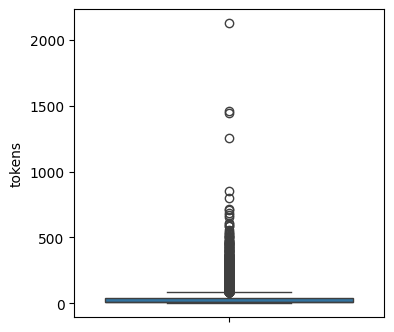

In [40]:
report_number_of_tokens(df['tokens'])

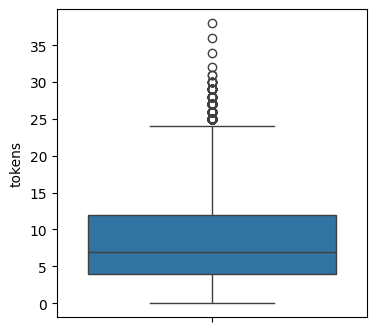

In [41]:
report_number_of_tokens(df[df['intention']==0]['tokens'])

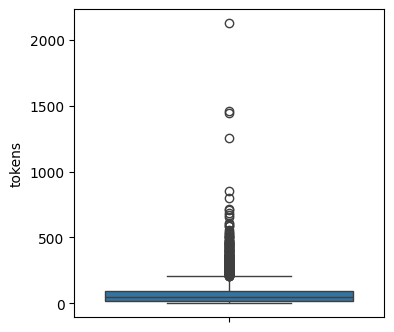

In [42]:
report_number_of_tokens(df[df['intention']==1]['tokens'])

In [43]:
df['tokens'].map(len)

0       42
1       22
2       32
3       29
4       10
        ..
9114    14
9115    10
9116    10
9117     8
9118    11
Name: tokens, Length: 9119, dtype: int64

In [44]:
df['tokens'].map(len).describe()

count    9119.000000
mean       37.306832
std        71.739727
min         0.000000
25%         6.000000
50%        12.000000
75%        37.000000
max      2129.000000
Name: tokens, dtype: float64

In [45]:
df[df['intention']==0]['tokens'].map(len).describe()

count    5121.000000
mean        8.951377
std         6.462405
min         0.000000
25%         4.000000
50%         7.000000
75%        12.000000
max        38.000000
Name: tokens, dtype: float64

In [46]:
df[df['intention']==1]['tokens'].map(len).describe()

count    3998.000000
mean       73.627064
std        96.629880
min         0.000000
25%        19.000000
50%        46.000000
75%        95.000000
max      2129.000000
Name: tokens, dtype: float64

In [47]:
ttest_ind(df[df['intention']==0]['tokens'].map(len),
    df[df['intention']==1]['tokens'].map(len), alternative='less')

TtestResult(statistic=-47.760969780965816, pvalue=0.0, df=9117.0)

In [128]:
def plot_wordcloud(df):
	all_tokens=[]
	for val in df.values:
		all_tokens.extend(val)
	wordcloud=WordCloud(width = 800, height = 800,
					background_color ='white',
					stopwords = STOPWORDS,
					min_font_size = 10).generate(' '.join(all_tokens))
	plt.figure(figsize = (8, 8), facecolor = None)
	plt.imshow(wordcloud)
	plt.axis("off")
	plt.tight_layout(pad = 0)
	plt.show()

Wordcloud of tweets without suicidal intention:


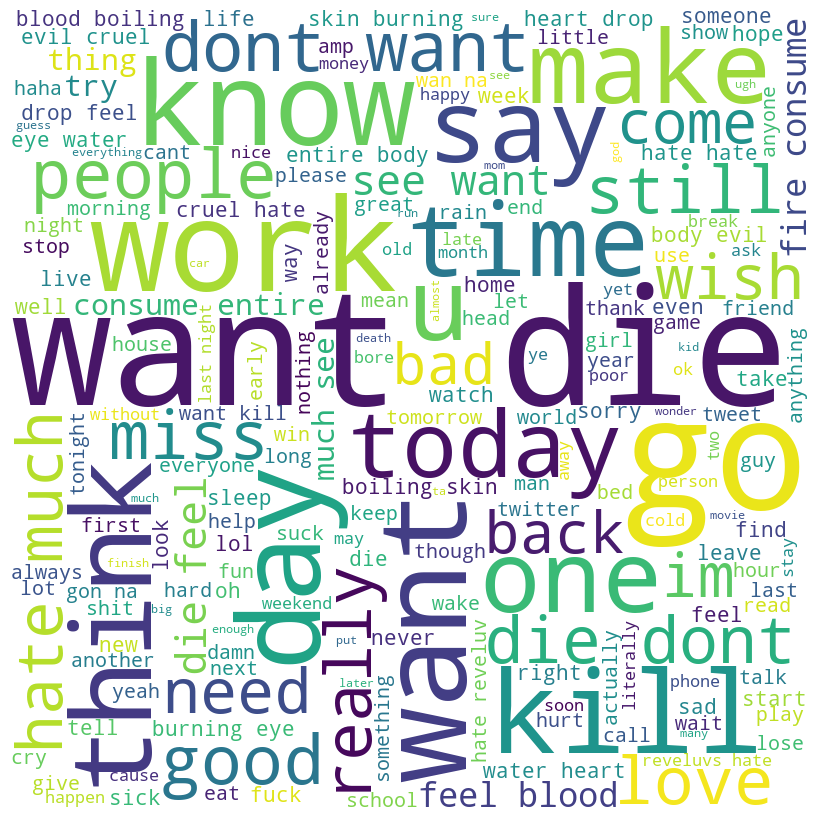

Wordcloud of tweets with suicidal intention:


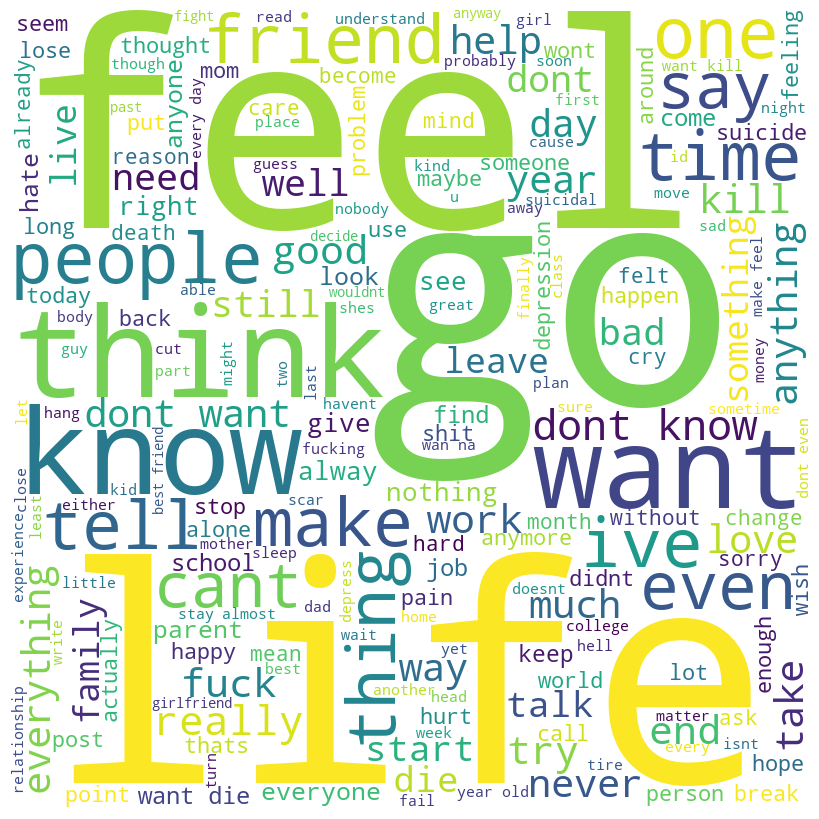

In [129]:
print('Wordcloud of tweets without suicidal intention:')
plot_wordcloud(df[df['intention']==0]['tokens'])
print('Wordcloud of tweets with suicidal intention:')
plot_wordcloud(df[df['intention']==1]['tokens'])

# Phase 1: Creating Feature Vectors

Here are some of the methods and techniques that can help us deal with OOV words in NLP tasks:
**Use subword units**: One way to handle OOV words is to use subword units, which are smaller segments of words that can capture the meaning and structure of words.
 For example, the word 'unbelievable' can be split into subword units like 'un', 'believ', and 'able'. Subword units can be learned from the training data using algorithms
  like byte pair encoding (BPE) or unigram language model (ULM). By using subword units, you can reduce the vocabulary size and increase the coverage of rare or unknown words.\
**Use character-level models**: Another way to handle OOV words is to use character-level models, which are models that operate on the level of individual characters instead of words
 or subwords. Character-level models can learn the spelling and morphology of words, and generate or recognize OOV words based on their character patterns.
 For example, a character-level model can infer that 'cat' and 'bat' are similar words based on their common suffix. Character-level models can be implemented
  using recurrent neural networks (RNNs), convolutional neural networks (CNNs), or transformers.
**Use embeddings and attention**: A third way to handle OOV words is to use embeddings and attention, which are techniques that can represent and align words in a semantic space. Embeddings are vector representations of words that capture their meaning and context. Attention is a mechanism that can learn the relevance and importance of different words in a sequence. By using embeddings and attention, you can map OOV words to similar or related words in the vocabulary, and improve the accuracy and fluency of NLP models. For example, an embedding and attention model can translate 'sushi' to 'raw fish' if 'sushi' is an OOV word in the target language.\
**Use data augmentation and transfer learning**: A fourth way to handle OOV words is to use data augmentation and transfer learning, which are methods that can enrich and leverage the available data. Data augmentation is the process of creating new or modified data from the existing data, using techniques like synonym replacement, word insertion, or back translation. Transfer learning is the process of applying the knowledge learned from one domain or task to another domain or task, using pre-trained models like BERT or GPT-3. By using data augmentation and transfer learning, you can increase the diversity and quality of the data, and reduce the impact of OOV words on the NLP models.\
**Use spell correction and normalization**: A fifth way to handle OOV words is to use spell correction and normalization, which are steps that can fix or standardize the input or output text. Spell correction is the task of detecting and correcting spelling errors or typos in the text, using methods like edit distance, n-gram models, or neural networks. Normalization is the task of converting the text to a consistent and canonical form, using methods like lowercasing, stemming, lemmatization, or removing punctuation. By using spell correction and normalization, you can reduce the noise and variability in the text, and avoid OOV words caused by spelling mistakes or different forms.\
**Use domain adaptation and active learning**: A sixth way to handle OOV words is to use domain adaptation and active learning, which are strategies that can adapt and improve the NLP models to new or specific domains. Domain adaptation is the technique of adjusting the parameters or features of a model trained on a general or source domain to a different or target domain, using methods like feature selection, weighting, or regularization. Active learning is the technique of selecting the most informative or uncertain samples from a pool of unlabeled data to be annotated and added to the training data, using methods like uncertainty sampling, query-by-committee, or expected error reduction. By using domain adaptation and active learning, you can tailor and update the NLP models to the domain-specific vocabulary and OOV words.\
**Use a Random Vector**: This is a straightforward and easy-to-implement approach. Ensures that all OOV words are treated uniformly. Random vectors do not capture any semantic meaning, potentially leading to poorer model performance. The randomness can introduce noise and variance into the model, which might affect consistency during training and inference.\
**Use a Special OOV Token**: All OOV words are mapped to a single, consistent vector. The model can explicitly learn to handle OOV words through this special token. Treating all OOV words as the same can lead to loss of nuance and potentially important distinctions between different OOV words. The effectiveness depends on how well the model can learn to handle this token based on the training data.\
**Subword Embeddings (e.g., FastText)**: Subword embeddings break words into smaller units (e.g., n-grams), which allows the model to infer embeddings for OOV words based on their components. This approach captures morphological and semantic relationships between words better than other methods. Implementing and integrating subword embeddings can be more complex. Training and storage might be more resource-intensive due to the larger vocabulary of subword units.\
**Nearest Neighbor Approximation**: Approximating OOV words with their nearest in-vocabulary neighbors can help preserve some semantic meaning. Usually performs better than assigning random vectors or a single OOV token. The approximation might not always be accurate, especially for words with unique meanings. Finding nearest neighbors can be computationally intensive, especially with large vocabularies.

## Word2Vec - Word Embedding

In [48]:
# print available word2vec models
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [49]:
W2V_PATH = 'w2v_model' # Path to W2V if downloaded
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

Loading Word2Vec model...
Word2Vec model is loaded.


In [50]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size

In [51]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"


        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        self.dataframe.loc[:,self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted  {lwz - len(self.dataframe)}-Len Samples: {len(self.dataframe)}")

        # Add padding
        self.dataframe.loc[:,self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        vectors = self.dataframe[self.df_token_col].map(self._get_word_vectors)
        self.dataframe=self.dataframe.assign(vector=vectors)

    def _get_word_vectors(self, tokens: list) -> torch.tensor:
      # TODO: Return a 2D tensor for whole list of tokens, using vectors from w2v as explained on the description
      return self._to_tensor(np.array([self.w2v_model[token] if token in self.w2v_model 
                                       else np.zeros(self.vector_size) for token in tokens]))

    def _pad(self, tokens: list):
        # TODO: Add paddings (zero-vectors) into the end of sequence to reach the desired length
        if len(tokens)<self.max_sequence_len:
            return np.pad(tokens,pad_width=(0,self.max_sequence_len-len(tokens)),mode='constant',constant_values ='')
        else:
            return tokens[:self.max_sequence_len]

    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}]")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}]")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

In [52]:
df=pd.read_csv(FILE_ADDR)

In [53]:
data=Twitter(df, w2v_model, SEQUENCE_LEN)

Deleted  37-Len Samples: 9082


In [54]:
data.seq_report()

Sequence Length Report
:::::MAX  LENGTH:::[ 64  ]
:::::MIN  LENGTH:::[ 64  ]
:::::MEAN LENGTH:::[64.0 ]
Sequence Tokenization Report
:::::All Unique Tokens:::[15770 ]
:::::All Valid Tokens:::[10638 ]
:::::Valid Tokens:::[67.46%]


# Phase 2: Classification using a CNN

**Vanilla GD (SGD)**:\
Precisely, stochastic gradient descent(SGD) refers to the specific case of vanilla GD when the batch size is 1. However, we will consider all mini-batch GD, SGD, and batch GD as SGD for convenience in this post.
SGD is the most basic form of GD. SGD subtracts the gradient multiplied by the learning rate from the weights. Despite its simplicity, SGD has strong theoretical foundations and is still used in training edge NNs.\
$$\theta_{i}=\theta_{i}-\alpha\frac{\partial L}{\partial \theta_{i}}$$
**Momentum**:\
Momentum is often referred to as rolling down a ball, as it is conceptually equal to adding velocity. The weights are modified through a momentum term, which is calculated as the moving average of gradients. The momentum term γ can be seen as air resistance or friction which decays the momentum proportionally. Momentum accelerates the training process but adds an additional hyperparameter.
Essentially, this equation is equal to subtracting the exponential decaying average of gradients.\
$$v_{i}=\gamma v_{i}+\alpha\frac{\partial L}{\partial \theta_{i}}$$
$$\theta_{i}=\theta_{i}-v_{i}$$
**RMSProp**:\
RMSProp is an unpublished work, essentially similar to momentum. If the gradients are consistently large, the values of v_i will increase, and the learning rate will decrease. This adaptively adjusts the learning rate for each parameter and enables the usage of larger learning rates.\
$$v_{i}=\beta v_{i}+(1-\beta)(\frac{\partial L}{\partial \theta_{i}})^{2}$$
$$\theta_{i}=\theta_{i}-\alpha\frac{(\frac{\partial L}{\partial \theta_{i}})}{\sqrt{v_{i}}+\epsilon}$$
**Adam**:\
Adam essentially combines RMSProp and momentum by storing both the individual learning rate of RMSProp and the weighted average of momentum. The momentum and RMSProp parameters are calculated as the equation below.
The parameters are divided by (1-decay factor) before being applied to the weights in the gradient descent step.
As in the equation above, Adam is based on RMSProp but estimates the gradient as the momentum parameter to improve training speed. According to several experiments, Adam outperformed all other methods in various training setups and experiments in the paper. Adam has become a default optimization algorithm regardless of fields. However, Adam introduces two new hyperparameters and complicates the hyperparameter tuning problem.\
$$m_{i}=\beta_{1} m_{i}+(1-\beta_{1})\frac{\partial L}{\partial \theta_{i}}$$
$$v_{i}=\beta_{2} v_{i}+(1-\beta_{2})(\frac{\partial L}{\partial \theta_{i}})^{2}$$
$$\hat{m_{l}}=\frac{m_{i}}{1-\beta_{1}}$$
$$\hat{v_{l}}=\frac{v_{i}}{1-\beta_{2}}$$
$$\theta_{i}=\theta_{i}-\frac{\alpha}{\sqrt{\hat{v_{l}}}+\epsilon}\hat{m_{l}}$$

One of the main advantages of cross-entropy loss is that it is easy to implement and optimize. Most neural network frameworks provide built-in functions for cross-entropy loss and its gradients. Cross-entropy loss also has a smooth and convex shape, which makes it easier for gradient-based optimization methods to find the global minimum.

Another advantage of cross-entropy loss is that it is invariant to scaling and shifting of the predicted probabilities. This means that multiplying or adding a constant to the predicted probabilities does not affect the cross-entropy loss value, as long as they are still between 0 and 1. This can be useful for regularization and calibration of the model's outputs.

Suicidal detection is typically framed as a binary classification problem, where each tweet is classified as either indicating suicidal intent or not. Cross-entropy loss is well-suited for binary classification tasks as it measures the performance of a classification model whose output is a probability value between 0 and 1.

CNN models often output probabilities (via a sigmoid or softmax activation function in the final layer) indicating the likelihood of each class. Cross-entropy loss is designed to work with these probabilistic outputs. Cross-entropy calculates the log loss between the actual labels and the predicted probabilities, effectively penalizing incorrect predictions more when they are confident but wrong.

Cross-entropy loss provides gradients that are generally more informative and stable for optimization, helping the CNN model to converge more efficiently during training. It strongly penalizes confident yet incorrect predictions, encouraging the model to not only make correct predictions but also be appropriately confident in them.

## Prepare Data

### Split Data into train-valid

In this assignment we have large enough sample (9119) so I've decided to use 10% for test and the rest (90%) for training the model.

In [55]:
train,valid=train_test_split(df,test_size=0.1,random_state=42)

### Create Datasets

In [56]:
train_dataset = Twitter(train, w2v_model, SEQUENCE_LEN)
valid_dataset = Twitter(valid, w2v_model, SEQUENCE_LEN)
print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")

Deleted  30-Len Samples: 8177
Deleted  7-Len Samples: 905
Train dataset length: 8177
Valid dataset length: 905


In [57]:
train_dataset.seq_report()

Sequence Length Report
:::::MAX  LENGTH:::[ 64  ]
:::::MIN  LENGTH:::[ 64  ]
:::::MEAN LENGTH:::[64.0 ]
Sequence Tokenization Report
:::::All Unique Tokens:::[14819 ]
:::::All Valid Tokens:::[10145 ]
:::::Valid Tokens:::[68.46%]


In [58]:
valid_dataset.seq_report()

Sequence Length Report
:::::MAX  LENGTH:::[ 64  ]
:::::MIN  LENGTH:::[ 64  ]
:::::MEAN LENGTH:::[64.0 ]
Sequence Tokenization Report
:::::All Unique Tokens:::[ 4068 ]
:::::All Valid Tokens:::[ 3299 ]
:::::Valid Tokens:::[81.1 %]


## Model and Train

Choosing the kernel size in a Convolutional Neural Network (CNN) is a crucial decision that directly impacts the network’s ability to extract meaningful features from input data. Here’s a detailed explanation of how to choose the kernel size:\
**Understand the Task and Data**:The kernel size should be chosen based on the characteristics of the data and the requirements of the task.
For tasks requiring detection of fine-grained details, smaller kernel sizes are often preferred. Conversely, larger kernel sizes are suitable for capturing broader patterns.\
**Consider Input Size and Complexity**:The size of the input data also influences the choice of kernel size. Smaller kernel sizes are generally more suitable for smaller input sizes, while larger input sizes can accommodate larger kernel sizes.\
For simple tasks or datasets with less complexity, smaller kernel sizes may be sufficient. However, more complex tasks or datasets may require larger kernel sizes to capture intricate features.\
**Balance Between Local and Global Information**:
Kernel size determines the receptive field of each convolutional operation. Smaller kernel sizes capture more local information, while larger kernel sizes capture more global information.\
It’s essential to strike a balance between capturing local details and considering broader context. Experimentation with different kernel sizes can help determine the optimal balance for the specific task.\
**Avoid Information Loss**: Choosing an excessively small kernel size may lead to information loss, especially in deeper layers of the network where the receptive field grows larger. In such cases, stacking multiple layers with small kernel sizes can help preserve information.\
Conversely, using excessively large kernel sizes may result in oversmoothing or loss of fine-grained details in the input data.\
**Experiment and Validate**: Experiment with different kernel sizes during model development and validation. Evaluate the performance of the CNN architecture with various kernel sizes on a validation set.
Techniques like grid search or random search can help systematically explore the hyperparameter space and identify the optimal kernel size.\
**Consider Computational Resources**: Larger kernel sizes require more computational resources for processing, both during training and inference. Therefore, it’s essential to consider the available resources and computational constraints when choosing the kernel size.

**Why Use Fully Connected Layers?**\
**Combining Features**: Convolutional layers and pooling layers extract and condense local features from the input data. Fully connected layers aggregate these features to make a final decision, ensuring that information from all parts of the image is considered in the prediction.\
**Non-linearity and Complexity**:\
Adding Non-linearities: Fully connected layers, combined with activation functions like ReLU, introduce non-linearities. This enables the model to learn complex mappings from inputs to outputs, which would be difficult with just convolutional layers.\
**Abstract Reasoning**: While convolutional layers are excellent at learning spatial hierarchies and local patterns, fully connected layers can learn higher-level reasoning and abstract representations, crucial for tasks like classification.\
**Advantages Over Direct Outputs from Convolutional Layers**:\
**Fixed Size Output**: FC layers can convert the high-dimensional feature maps from convolutional layers into a fixed-size output, suitable for final classification or regression tasks.\
**Global Information**: FC layers integrate information from the entire image, capturing global context which is essential for making accurate predictions.\
**Versatile Architectures**: The combination of convolutional and fully connected layers allows for more flexible and powerful network architectures, capable of handling various types of input data and learning intricate patterns.\
**Feature Vectors**: The output of FC layers is a feature vector that can be used with traditional machine learning classifiers if needed. This compatibility adds to the flexibility in designing hybrid models.\
**Comparison with Other Methods**:\
**Global Average Pooling (GAP)**: Some modern architectures replace FC layers with GAP layers to reduce the risk of overfitting and to reduce the number of parameters.
Advantages of FC over GAP: While GAP layers reduce parameters and risk of overfitting, FC layers are more expressive and can model complex functions, which can be beneficial for certain tasks where high accuracy is critical.\
**Direct Convolutional Outputs**: Directly using the output from convolutional layers can be insufficient for tasks requiring complex decision boundaries.

### Utils

In [59]:
@torch.no_grad()
def model_eval(model, loader, loss_function, device: ['cuda', 'cpu', 'auto']):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device,non_blocking=True)
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        # TODO: move model's inputs to `device`
        inputs, labels = inputs.to(device,non_blocking=True), labels.to(device,non_blocking=True)
        # TODO: use model's forward pass to generate outputs
        outputs = model(inputs)
        predictions=torch.argmax(outputs, dim=1)
        # TODO: calculate model's loss
        loss = loss_function(outputs, labels)
        # TODO: calculate/update model's accuracy
        test_loss += loss.item()
        test_acc += (predictions == labels).sum().item()
        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(test_acc, 5),
        )

    return test_loss, test_acc/len(loader.dataset)

In [60]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device: ['cuda', 'cpu', 'auto'],
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device,non_blocking=True)

    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []

    # TODO: create dataloaders from datasets
    train_loader =DataLoader(dataset = train_set,
                                           batch_size = batch_size,
                                           shuffle = True,pin_memory=True)
    valid_loader =DataLoader(dataset = valid_set,
                                           batch_size = batch_size,
                                           shuffle = True,pin_memory=True)
    model.to(device,non_blocking=True)
    itr_epoch=tqdm(range(epochs),total=epochs, leave=False)
    itr = tqdm(train_loader, total=len(train_loader), leave=False)

    for epoch in itr_epoch:
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        for inputs, labels in itr:
            # TODO: move model's inputs to `device`
            inputs, labels = inputs.to(device,non_blocking=True), labels.to(device,non_blocking=True)
            # TODO: use model's forward pass to generate outputs
            outputs=model.forward(inputs)
            # TODO: process model's predictipns and calculate/update accuracy
            predictions=torch.argmax(outputs, dim=1)
            epoch_acc+=(predictions == labels).sum().item()
            # TODO: calculate model's loss and update epoch's loss
            loss = loss_function(outputs, labels)
            epoch_loss+=loss.item()
            # TODO: 1. clear optimizer's state and zero prev grads,
            optimizer.zero_grad()
            # TODO: 2. backward calculated loss
            loss.backward()
            # TODO: 3. step optimizer
            optimizer.step()

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
              loss=round(loss.item(), 5),
              accuracy=round(epoch_acc, 5),
              )

        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
            )

        # TODO: update statistics regaurding model's loss and acc in training or validation phases
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc/len(train_loader.dataset))
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    history = {
      "train_loss": train_losses,
      "train_acc": train_accs,

      "valid_loss": valid_losses,
      "valid_acc": valid_accs,
    }
    return history

In [61]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [62]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device,non_blocking=True)

    loader = DataLoader(dataset, batch_size=32, shuffle=False,pin_memory=True)
    itr = tqdm(loader, leave=False, desc="Generate data")

    # TODO: code here, you must fill variables below
    # TODO: labels = true labels from the dataset
    # TODO: predicted = labels predicted by the model
    labels = []
    predicted = []
    for inputs, label in itr:
        inputs, label = inputs.to(device,non_blocking=True), label.to(device,non_blocking=True)
        output = model.forward(inputs)
        pred = torch.argmax(output, dim=1)
        labels.extend(label)
        predicted.extend(pred)
    labels=[label.cpu().numpy() for label in labels]
    predicted=[pred.cpu().numpy() for pred in predicted]
    cm = metrics.confusion_matrix(
        y_true=labels,
        y_pred=predicted,
    )

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    accuracy = metrics.accuracy_score(y_true=labels, y_pred=predicted)
    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'accuracy':accuracy,'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


### Model's Network

In [77]:
class CNN(nn.Module):
    def __init__(self,embedding_dim, sequence_len, num_classes, cnn_filters,batch_size): # TODO: define your args here
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(sequence_len, cnn_filters, 3)
        self.pool1=nn.MaxPool1d(2)
        self.flatten=nn.Flatten()
        self.fc1=nn.Linear(9536,num_classes)
        # TODO: define you network's layers here

    def forward(self, x):
        # TODO: implement forward pass here
        x = self.conv1(x)
        x = self.pool1(F.relu(x))
        x = self.flatten(F.relu(x))
        x = self.fc1(F.relu(x))
        return x

### Training

Increasing batch_size decreases accuracy and execution time while decreasing it increases accuracy and execution time. Furthermore, by decreasing the batch size I reached the best answer faster(52 epochs instead of 112).\
Increasing learning rate increases accuracy though after some point it decreases accuracy unless we increase epochs.

In [76]:
BATCH_SIZE=4

In [55]:
cnn_model=CNN(EMBEDDING_VECTOR_DIM,SEQUENCE_LEN,NUM_CLASSES,CNN_FILTERS,BATCH_SIZE)

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE/10,weight_decay=WEIGHT_DECAY/10)
cnn_model_train_history = train_model( # TODO: train your model
    cnn_model,BATCH_SIZE,criterion,optimizer,300,train_dataset,valid_dataset,'auto'
)

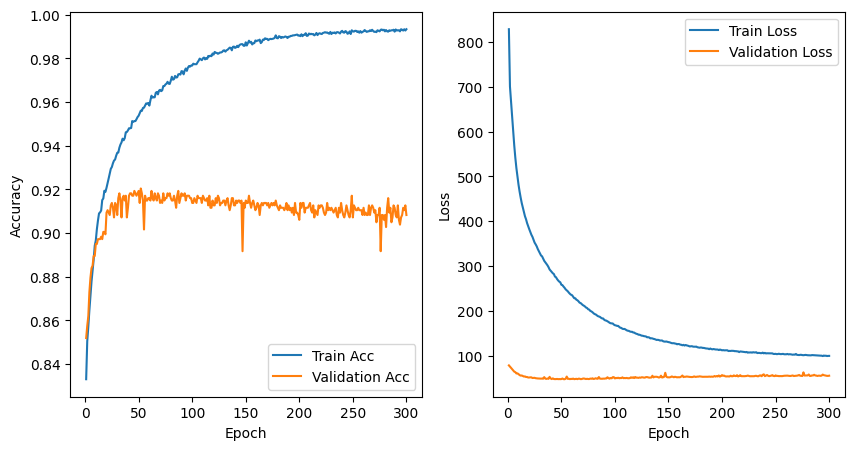

In [57]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

![title](output.png)

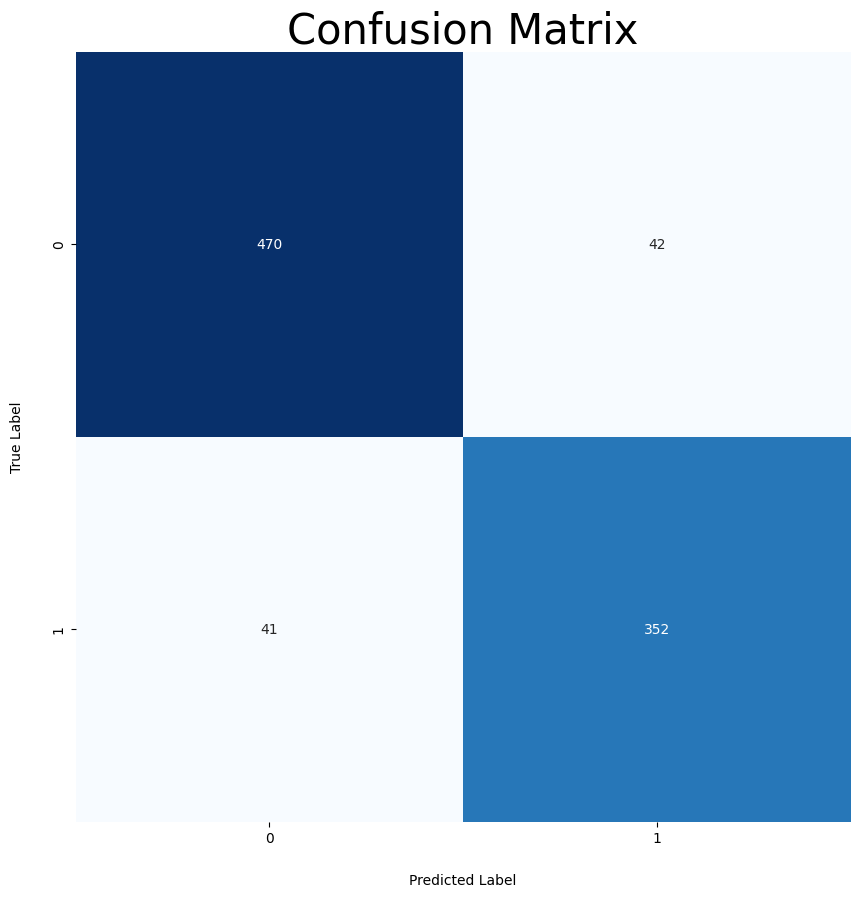

In [58]:
cnn_model_report = generate_confusion_matrix(
    model=cnn_model,
    dataset=valid_dataset,
)

In [59]:
print(f"Accuracy:    {cnn_model_report['accuracy']:.3f}")
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Accuracy:    0.908
Recall:    0.907
F1:        0.907
Precision: 0.907
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       512
           1       0.89      0.90      0.89       393

    accuracy                           0.91       905
   macro avg       0.91      0.91      0.91       905
weighted avg       0.91      0.91      0.91       905



differrent batch learning rate

In [126]:
peak_index=np.argmin(cnn_model_train_history['valid_loss'])
peak_index

52

In [61]:
cnn_model_peak=CNN(EMBEDDING_VECTOR_DIM,SEQUENCE_LEN,NUM_CLASSES,CNN_FILTERS,BATCH_SIZE)

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE/10,weight_decay=WEIGHT_DECAY/10)
cnn_model_train_history = train_model( # TODO: train your model
    cnn_model_peak,BATCH_SIZE,criterion,optimizer,peak_index+1,train_dataset,valid_dataset,'auto'
)

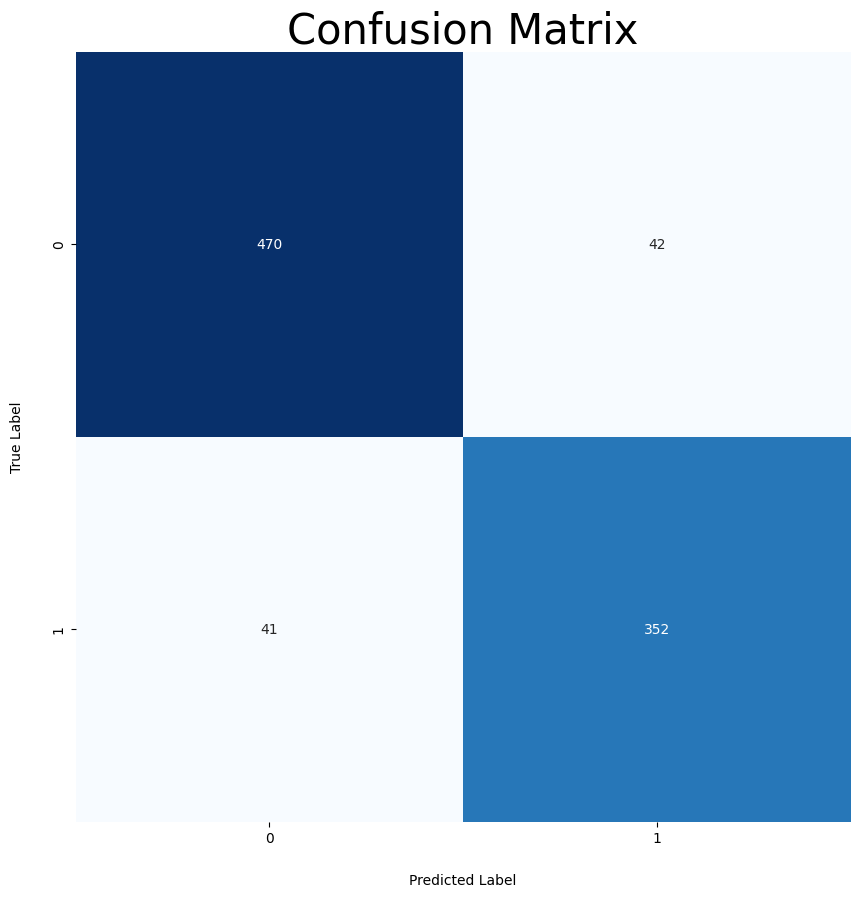

In [63]:
cnn_model_report = generate_confusion_matrix(
    model=cnn_model,
    dataset=valid_dataset,
)

In [64]:
print(f"Accuracy:    {cnn_model_report['accuracy']:.3f}")
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Accuracy:    0.908
Recall:    0.907
F1:        0.907
Precision: 0.907
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       512
           1       0.89      0.90      0.89       393

    accuracy                           0.91       905
   macro avg       0.91      0.91      0.91       905
weighted avg       0.91      0.91      0.91       905



In [65]:
torch.save(cnn_model_peak.state_dict(),'cnn_model_peak')

In [79]:
cnn_model_all_train = CNN(EMBEDDING_VECTOR_DIM,SEQUENCE_LEN,NUM_CLASSES,CNN_FILTERS,BATCH_SIZE)
cnn_model_all_train.load_state_dict(torch.load('cnn_model_peak'))

<All keys matched successfully>

I thought it would be a good idea to test the model with my own data. Though, we can see it doesn't perform well. I guess I'm not good at producing suicidal sentences....

In [67]:
my_valid_data=pd.DataFrame({'tweet':{
    0:'It was a pleasure to work on this assignment and learn how to work with CNNs. Though, it was more difficult than what I thought would be...',
    1:'I\'m tired of studying day to night for exams and doing assignments all the time ;( I don\'t want this life... I can\'t bear it anymore some body ghelp',
    2:'I wish I were close to my parents\' home. I don\'t know what they\'re doing or who is with them.',
    3:'Next month, I want to take my parents on a trip and make sure they have a great time.'}, 'intention': {
    0:0,1:1,2:1,3:0
}})
my_valid_data_set=Twitter(my_valid_data,w2v_model,SEQUENCE_LEN)

Deleted  0-Len Samples: 4


In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model_all_train.parameters(), lr=LEARNING_RATE/10,weight_decay=WEIGHT_DECAY/10)
cnn_model_train_history = train_model( # TODO: train your model
    cnn_model_all_train,BATCH_SIZE,criterion,optimizer,peak_index+1,valid_dataset,my_valid_data_set,'auto')

c:\Users\Home\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Home\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Home\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

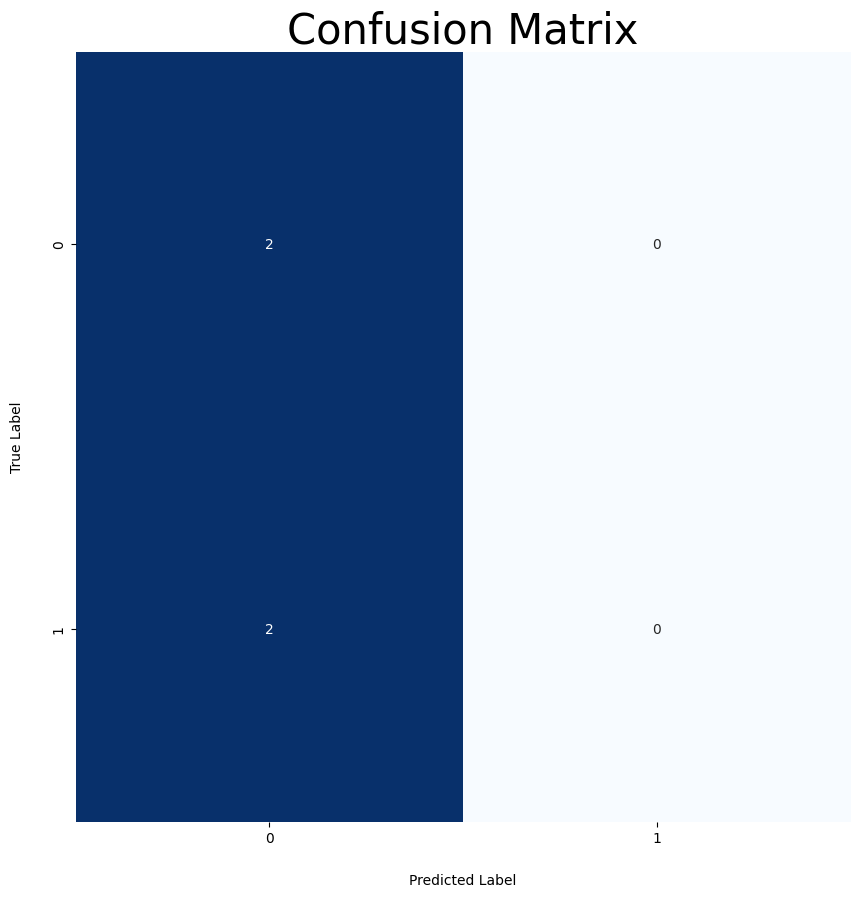

In [69]:
cnn_model_report = generate_confusion_matrix(
    model=cnn_model_all_train,
    dataset=my_valid_data_set,
)

# Phase 3: Impact of Context Window Size

Large context windows have several benefits. Some of the most notable benefits include the following:\
**Saves time**: The generative AI tool pinpoints the data sets on either side of the target token, avoiding irrelevant data in relation to the input target token. In fact, a well-defined context window, especially a larger context window, can expedite operations.\
**Accepts large inputs**: A large context window is a strong indicator of the semantic capability of LLMs to manage tokens. LLMs support linguistic searches in the vector database using word embeddings, ultimately generating relevant responses through an understanding of the terms related to the target token.\
**Provides detailed analysis**: A context window operates to the left and right of the target token to deeply analyze the data. The placement of importance scores enables the summarization of an entire document. Scrutiny of many tokens boosts research, learning and AI-based enterprise operations.\
**Allows for token adjustment**: The encoder-decoder in LLMs utilizes mechanisms such as "attention heads" for a better understanding of contextual dependencies. In long context-length use cases, an LLM can selectively focus on the relevant side of the target token to avoid extraneous responses. Indeed, token usage optimization ensures rapid processing of lengthy text while identifying and preserving its relevancy.\
There are some issues to consider with large context windows, including the following:\
**Accuracy declines**: AI hallucination is the inability to distinguish between tokens in large context windows. A Stanford study shows that AI performance degrades with large data sets, providing inaccurate information.\
**More time and energy are required**: Large context windows operate across numerous complex data sets, increasing the response time. The average time spent in entering input and output generation requires higher processing power and consumes more electricity.\
**Costs increase**: To maintain information accuracy in long context windows, the computational costs for generative AI tools increase by a factor of four. Higher pricing is a direct result of larger context lengths.

In [72]:
train_dataset1 = Twitter(train, w2v_model, 196)
valid_dataset1 = Twitter(valid, w2v_model, 196)
print(f"Train dataset length: {len(train_dataset1)}")
print(f"Valid dataset length: {len(valid_dataset1)}")

Deleted  30-Len Samples: 8177
Deleted  7-Len Samples: 905
Train dataset length: 8177
Valid dataset length: 905


In [73]:
train_dataset1.seq_report()

Sequence Length Report
:::::MAX  LENGTH:::[ 196 ]
:::::MIN  LENGTH:::[ 196 ]
:::::MEAN LENGTH:::[196.0]
Sequence Tokenization Report
:::::All Unique Tokens:::[18069 ]
:::::All Valid Tokens:::[11714 ]
:::::Valid Tokens:::[64.83%]


In [74]:
valid_dataset1.seq_report()

Sequence Length Report
:::::MAX  LENGTH:::[ 196 ]
:::::MIN  LENGTH:::[ 196 ]
:::::MEAN LENGTH:::[196.0]
Sequence Tokenization Report
:::::All Unique Tokens:::[ 4843 ]
:::::All Valid Tokens:::[ 3847 ]
:::::Valid Tokens:::[79.43%]


In [78]:
cnn_model1=CNN(EMBEDDING_VECTOR_DIM,196,NUM_CLASSES,CNN_FILTERS,BATCH_SIZE)

In [80]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model1.parameters(), lr=LEARNING_RATE/10,weight_decay=WEIGHT_DECAY/10)
cnn_model_train_history1 = train_model( # TODO: train your model
    cnn_model1,BATCH_SIZE,criterion,optimizer,300,train_dataset1,valid_dataset1,'auto'
)

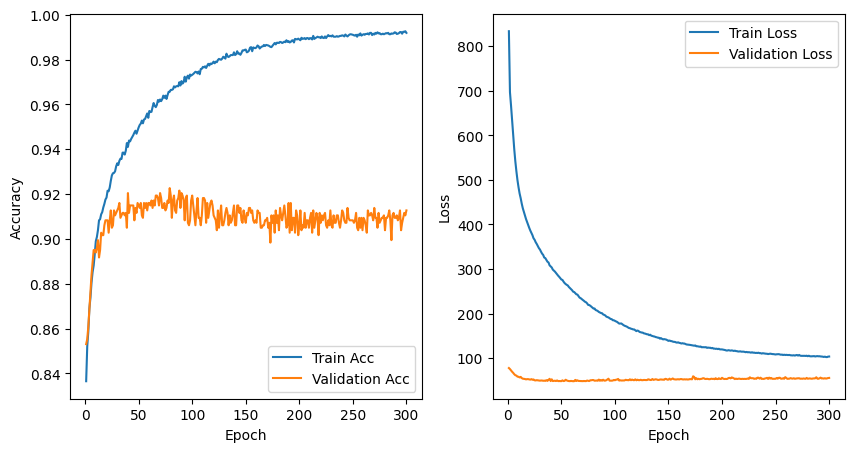

In [81]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history1["train_acc"]),
            ("Validation Acc", cnn_model_train_history1["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history1["train_loss"]),
            ("Validation Loss", cnn_model_train_history1["valid_loss"])
        ]
    }
)

![title](output1.png)

In [82]:
peak_index=np.argmin(cnn_model_train_history1['valid_loss'])
peak_index

60

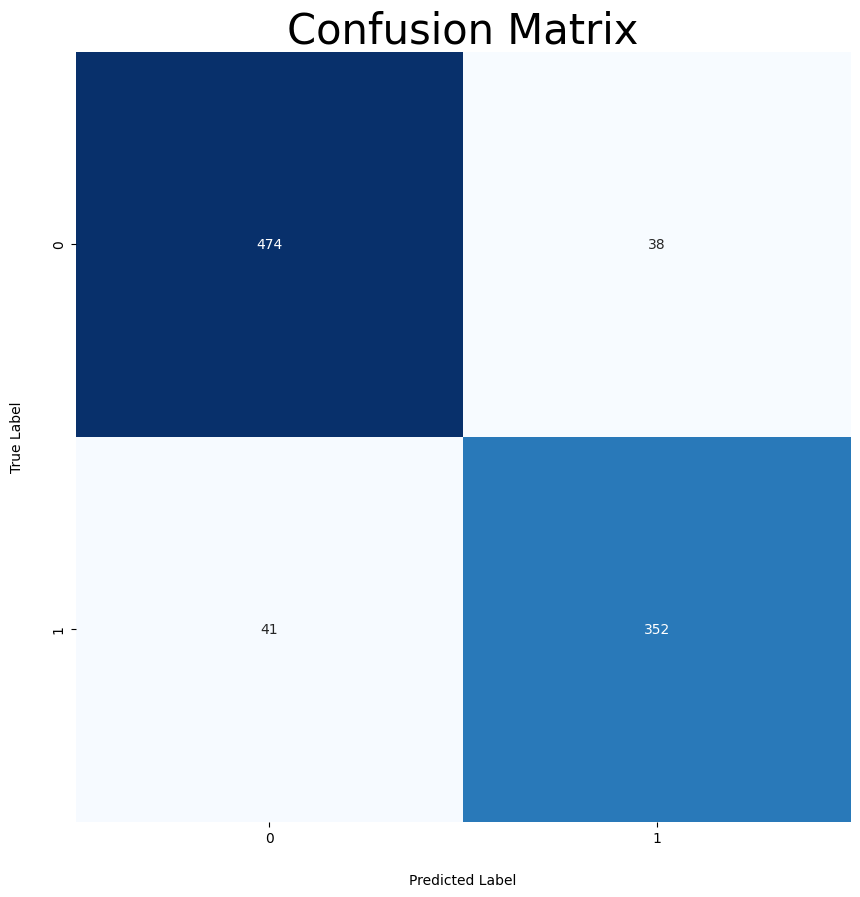

In [83]:
cnn_model_report = generate_confusion_matrix(
    model=cnn_model1,
    dataset=valid_dataset1,
)

In [84]:
print(f"Accuracy:    {cnn_model_report['accuracy']:.3f}")
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Accuracy:    0.913
Recall:    0.911
F1:        0.911
Precision: 0.911
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       512
           1       0.90      0.90      0.90       393

    accuracy                           0.91       905
   macro avg       0.91      0.91      0.91       905
weighted avg       0.91      0.91      0.91       905



We can see although increasing the context window size increased the resource utilization such as usage of memory, the accuracy increased a bit though it takes longer to reach its best solution(60 epochs instead of 52).

# Phase 4: Impact of Regularization Techniques in Training

In [63]:
class CNN1(nn.Module):
    def __init__(self,embedding_dim, sequence_len, num_classes, cnn_filters): # TODO: define your args here
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv1d(sequence_len, cnn_filters, 3)
        self.batch = nn.BatchNorm1d(cnn_filters)
        self.drop1 = nn.Dropout1d()
        self.pool1=nn.MaxPool1d(2)
        self.flatten=nn.Flatten()
        self.fc1=nn.Linear(9536,num_classes)
        # TODO: define you network's layers here
    def forward(self, x):
        # TODO: implement forward pass here
        x = self.conv1(x)
        x = self.batch((x))
        x = self.drop1(F.relu(x))
        x = self.pool1(F.relu(x))
        x = self.flatten(F.relu(x))
        x = self.fc1(F.relu(x))
        return x

In [64]:
BATCH_SIZE=32

In [65]:
cnn_model2=CNN1(EMBEDDING_VECTOR_DIM,SEQUENCE_LEN,NUM_CLASSES,CNN_FILTERS)

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model2.parameters(), lr=LEARNING_RATE/10,weight_decay=WEIGHT_DECAY/10)
cnn_model_train_history2 = train_model( # TODO: train your model
    cnn_model2,BATCH_SIZE,criterion,optimizer,1000,train_dataset,valid_dataset,'auto'
)

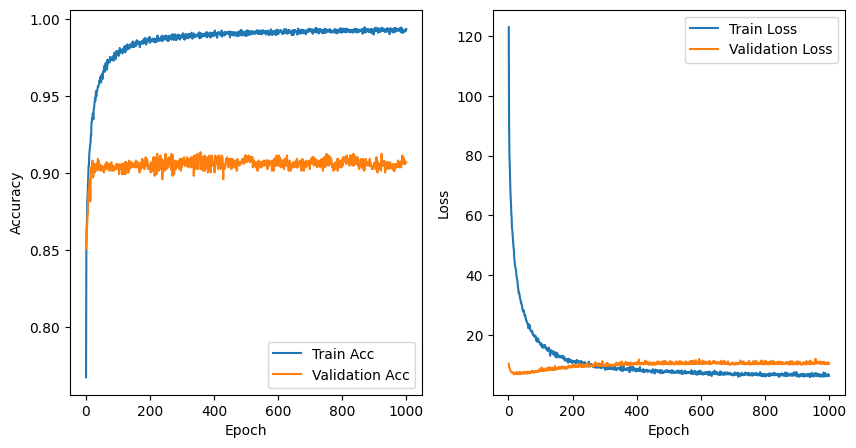

In [67]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history2["train_acc"]),
            ("Validation Acc", cnn_model_train_history2["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history2["train_loss"]),
            ("Validation Loss", cnn_model_train_history2["valid_loss"])
        ]
    }
)

In [70]:
peak_index=np.argmin(cnn_model_train_history2['valid_loss'])
peak_index

34

We can see using batch normalization and dropout layers changes the plot such that the slope of loss in validation dataset gets so smaller and the line gets close to a horizontal line so it's effective in dealing with overfitting. Also the model reaches the best answer faster(34 epochs instead of 52).

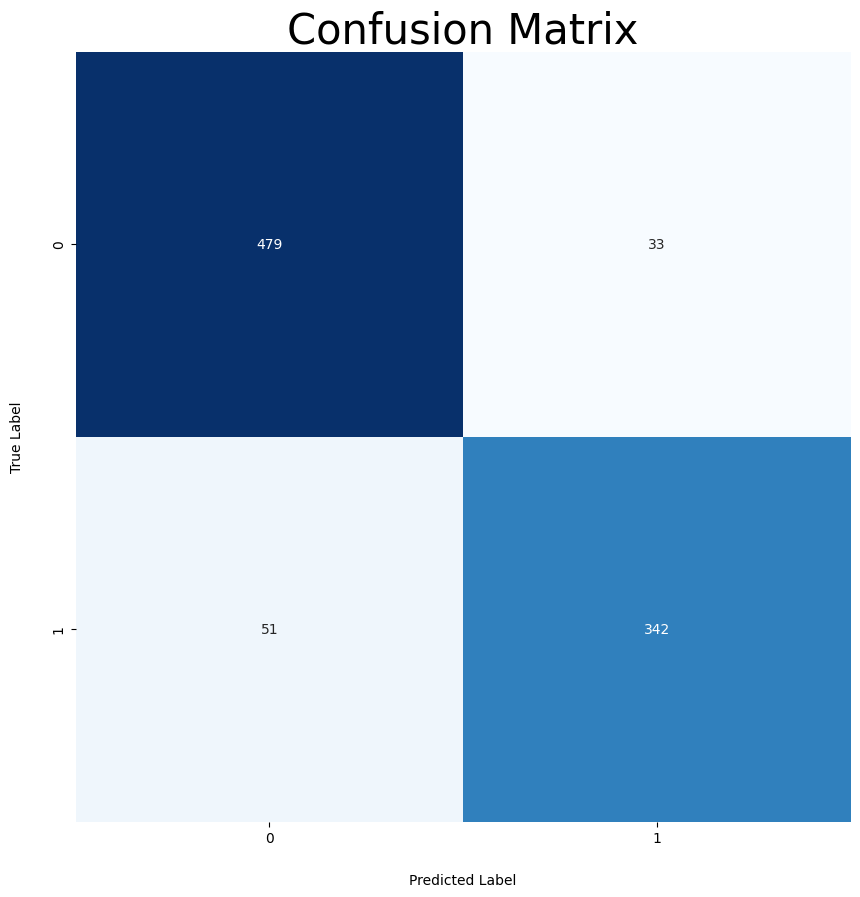

In [68]:
cnn_model_report = generate_confusion_matrix(
    model=cnn_model2,
    dataset=valid_dataset,
)

In [69]:
print(f"Accuracy:    {cnn_model_report['accuracy']:.3f}")
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Accuracy:    0.907
Recall:    0.903
F1:        0.905
Precision: 0.908
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       512
           1       0.91      0.87      0.89       393

    accuracy                           0.91       905
   macro avg       0.91      0.90      0.91       905
weighted avg       0.91      0.91      0.91       905



## References

https://medium.com/@kohlishivam5522/preprocessing-text-for-nlp-1f21ff2e4a1d\
https://www.analyticsvidhya.com/blog/2022/01/text-cleaning-methods-in-nlp\
https://www.geeksforgeeks.org/text-preprocessing-in-python-set-1\
https://medium.com/@maleeshadesilva21/preprocessing-steps-for-natural-language-processing-nlp-a-beginners-guide-d6d9bf7689c9\\
https://www.linkedin.com/advice/0/how-can-you-handle-out-of-vocabulary-words-nlp\
https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008\
https://www.linkedin.com/advice/0/what-advantages-disadvantages-using-cross-entropy\
https://www.geeksforgeeks.org/how-to-choose-kernel-size-in-cnn/\
https://stackoverflow.com/questions/42317238/why-do-we-use-fully-connected-layer-at-the-end-of-cnn\
https://www.techtarget.com/whatis/definition/context-window
